In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
file = '/content/drive/MyDrive/FOOD.zip'

In [29]:
import zipfile as zf
data_zip = zf.ZipFile(file)
data_zip.extractall()
!ls

 drive	'Food Classification dataset'   sample_data


In [31]:
from pathlib import Path
data = Path(r'/content/Food Classification dataset')

In [32]:
images=[]
import os
for dirname,_,filenames in os.walk(data):
  for filename in filenames:
    file_name, file_extension = os.path.splitext(filename)
    if file_extension == '.db':
      continue
    else:
      img=os.path.join(dirname,filename)
      images.append(img)

In [33]:
images[:20]

['/content/Food Classification dataset/masala_dosa/303.jpg',
 '/content/Food Classification dataset/masala_dosa/309.jpg',
 '/content/Food Classification dataset/masala_dosa/143.jpg',
 '/content/Food Classification dataset/masala_dosa/217.jpg',
 '/content/Food Classification dataset/masala_dosa/035.jpg',
 '/content/Food Classification dataset/masala_dosa/146.jpg',
 '/content/Food Classification dataset/masala_dosa/176.jpg',
 '/content/Food Classification dataset/masala_dosa/055.jpg',
 '/content/Food Classification dataset/masala_dosa/117.jpg',
 '/content/Food Classification dataset/masala_dosa/101.jpg',
 '/content/Food Classification dataset/masala_dosa/005.jpg',
 '/content/Food Classification dataset/masala_dosa/136.jpg',
 '/content/Food Classification dataset/masala_dosa/download (1).jpg',
 '/content/Food Classification dataset/masala_dosa/229.jpg',
 '/content/Food Classification dataset/masala_dosa/139.jpg',
 '/content/Food Classification dataset/masala_dosa/044.jpg',
 '/content/Food

In [34]:
len(images)

23873

In [35]:
class_values = []
for i in images:
    j = i.split('/')
    class_values.append(j[-2])

In [36]:
class_values[:10]

['masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa',
 'masala_dosa']

In [37]:
len(class_values)

23873

In [38]:
import random # Import the random module at the beginning of the cell
temp = list(zip(images,class_values))
random.shuffle(temp)
images, class_values = zip(*temp)
data = pd.DataFrame(list(zip(images, class_values)), columns=['image_path', 'Class_label'])

In [39]:
data

,image_path,Class_label
0,/content/Food Classification dataset/Taquito/T...,Taquito
1,/content/Food Classification dataset/chicken_c...,chicken_curry
2,/content/Food Classification dataset/cheesecak...,cheesecake
3,/content/Food Classification dataset/ice_cream...,ice_cream
4,/content/Food Classification dataset/chapati/3...,chapati
...,...,...
23868,/content/Food Classification dataset/Sandwich/...,Sandwich
23869,/content/Food Classification dataset/sushi/120...,sushi
23870,/content/Food Classification dataset/Fries/Fri...,Fries
23871,/content/Food Classification dataset/Hot Dog/H...,Hot Dog


In [40]:
data.shape

(23873, 2)

In [41]:
data.Class_label.value_counts()

,count
Class_label,
Hot Dog,1548
Taquito,1500
Taco,1500
Crispy Chicken,1500
Baked Potato,1500
Donut,1500
Fries,1500
Sandwich,1500
chicken_curry,1000


In [42]:
from sklearn.utils import resample

# Convert to DataFrame
df = data.copy()

# Number of samples per class
TARGET_COUNT = 500
balanced_df = []

# Loop over each unique class
for label in df['Class_label'].unique():
    df_class = df[df['Class_label'] == label]

    # Resample
    df_resampled = resample(df_class,
                            replace=True,
                            n_samples=TARGET_COUNT,
                            random_state=42)
    balanced_df.append(df_resampled)

# Concatenate all into one DataFrame
balanced_df = pd.concat(balanced_df).reset_index(drop=True)

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Final check
print(balanced_df['Class_label'].value_counts())


Class_label
burger            500
omelette          500
dhokla            500
chapati           500
kadai_paneer      500
Hot Dog           500
Sandwich          500
chole_bhature     500
kaathi_rolls      500
chai              500
Taquito           500
paani_puri        500
masala_dosa       500
sushi             500
idli              500
pizza             500
butter_naan       500
samosa            500
dal_makhani       500
jalebi            500
fried_rice        500
cheesecake        500
pakode            500
Donut             500
Taco              500
Fries             500
momos             500
apple_pie         500
kulfi             500
pav_bhaji         500
Crispy Chicken    500
ice_cream         500
Baked Potato      500
chicken_curry     500
Name: count, dtype: int64


In [43]:
balanced_df['Class_label'] = balanced_df['Class_label'].astype(str)

In [44]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['Class_label'],
    random_state=42
)


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [46]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='Class_label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='Class_label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 13600 validated image filenames belonging to 34 classes.
Found 3400 validated image filenames belonging to 34 classes.


In [47]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False


In [48]:
# Get number of classes from train_generator
num_classes = len(train_generator.class_indices)

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [50]:
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
142/425 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.0419 - loss: 3.8191

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


425/425 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.0750 - loss: 3.5767 - val_accuracy: 0.4424 - val_loss: 2.4560
Epoch 2/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 973s 2s/step - accuracy: 0.3194 - loss: 2.5214 - val_accuracy: 0.6362 - val_loss: 1.5539
Epoch 3/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - accuracy: 0.4775 - loss: 1.9066 - val_accuracy: 0.6924 - val_loss: 1.2105
Epoch 4/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 949s 2s/step - accuracy: 0.5542 - loss: 1.5924 - val_accuracy: 0.7200 - val_loss: 1.0617
Epoch 5/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 940s 2s/step - accuracy: 0.5850 - loss: 1.4560 - val_accuracy: 0.7379 - val_loss: 0.9608
Epoch 6/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 932s 2s/step - accuracy: 0.6264 - loss: 1.3048 - val_accuracy: 0.7512 - val_loss: 0.9005
Epoch 7/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 924s 2s/step - accuracy: 0.6519 - loss: 1.2237 - val_accuracy: 0.7644 - val_loss: 0.8487
Epoch 8/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 981s 2s/step - accuracy: 0.6654 - loss: 1.1572 - val_accuracy: 0.77

In [51]:
model.save("Food.h5")

In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")

107/107 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8397 - loss: 0.5333
Validation Accuracy: 84.03%


In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict on the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class indices

# True labels
y_true_classes = val_generator.classes

# Class labels (names)
class_labels = list(val_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


107/107 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step
Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.89      0.79      0.84       100
Crispy Chicken       0.89      0.55      0.68       100
         Donut       0.92      0.88      0.90       100
         Fries       0.87      0.81      0.84       100
       Hot Dog       0.78      0.85      0.81       100
      Sandwich       0.86      0.67      0.75       100
          Taco       0.72      0.63      0.67       100
       Taquito       0.79      0.57      0.66       100
     apple_pie       0.72      0.56      0.63       100
        burger       0.90      0.98      0.94       100
   butter_naan       0.94      0.81      0.87       100
          chai       0.92      1.00      0.96       100
       chapati       0.79      0.85      0.82       100
    cheesecake       0.79      0.76      0.78       100
 chicken_curry       0.81      0.70      0.75       100
 chole_bhature       0.80      0.90   

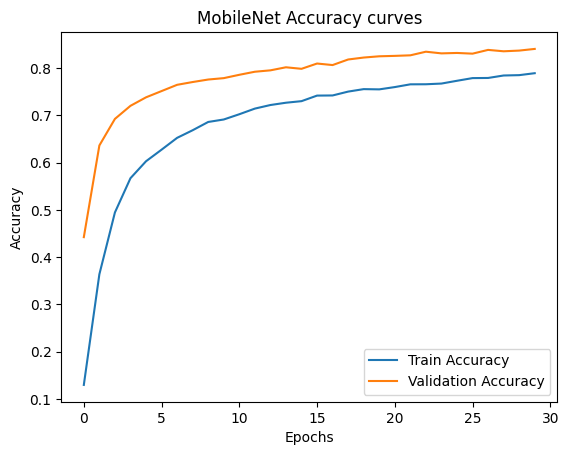

In [56]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("MobileNet Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

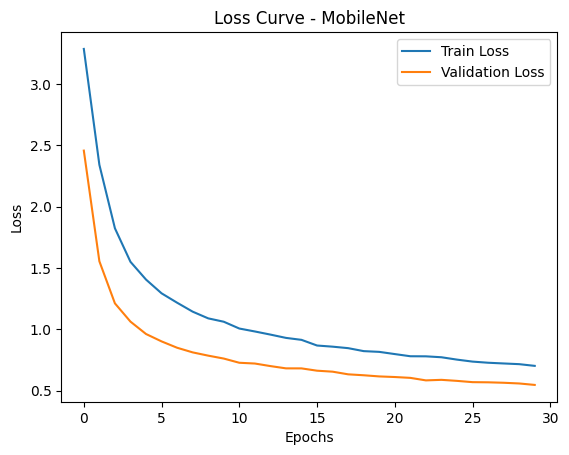

In [57]:
# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step


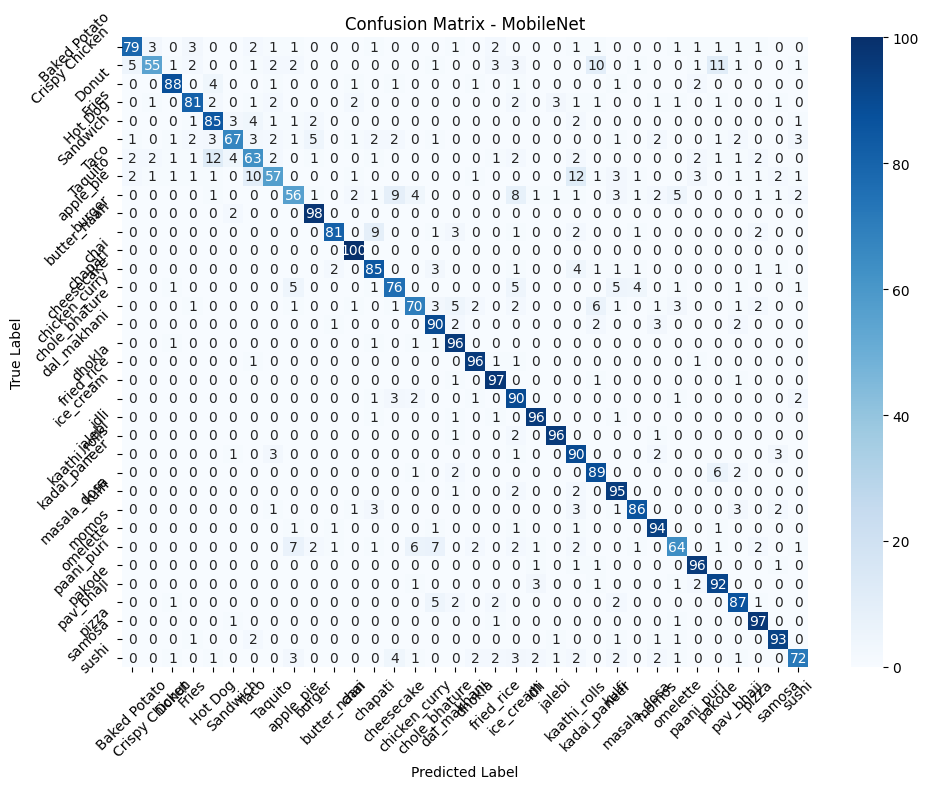

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true_classes = val_generator.classes

# Get class names from generator
class_labels = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MobileNet")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: momos
Actual class: momos


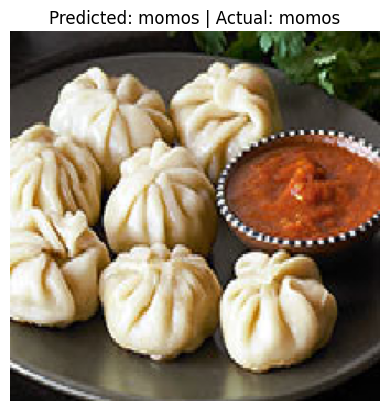

In [61]:
# Pick an index from the validation generator
i = 5

# Get image and label
img, label = val_generator[i]
img_single = img[0]  # Take one image
label_single = label[0]

# Predict
prediction = model.predict(np.expand_dims(img_single, axis=0))
pred_class = np.argmax(prediction)
actual_class = np.argmax(label_single)

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Print results
print("Predicted class: {}".format(class_labels[pred_class]))
print("Actual class: {}".format(class_labels[actual_class]))

# Show image
plt.imshow((img_single + 1) / 2)  # Reverse MobileNetV2 preprocessing ([-1,1] -> [0,1])
plt.axis("off")
plt.title(f"Predicted: {class_labels[pred_class]} | Actual: {class_labels[actual_class]}")
plt.show()
